In [1]:
from obspy import read as oread

In [2]:
from os.path import dirname, join as pjoin
from os import listdir

In [3]:
from datetime import datetime as dt

In [4]:
import numpy as np
import scipy.io.wavfile

In [5]:
year = 1969
month = 11
day = 19
day_of_year = dt(year=year, month=month, day=day).timetuple().tm_yday

miniseedroot = '/Users/alex/Downloads/Apollo/{}/'.format(year)
station = 'S12'
channel = 'MH1'
subfolder = pjoin(miniseedroot, station, channel)

seedfilename = '{}.XA..{}.{}.{}'.format(station, channel, year, day_of_year)
seedfilepath = pjoin(subfolder, seedfilename)

In [6]:
st = oread(seedfilepath)
print(st)

1 Trace(s) in Stream:
XA.S12..MH1 | 1969-11-19T14:23:22.942900Z - 1969-11-19T23:59:59.924032Z | 6.6 Hz, 229206 samples


In [7]:
wf = st[0].data

In [8]:
scipy.io.wavfile.write('{}-{}-{}{}.wav'.format(station, channel, year, day_of_year), 8000, wf/512)

In [92]:
year = 1970
miniseedroot = '/Users/alex/Downloads/Apollo/{}/'.format(year)
station = 'S12'

for ch in ('MH1','MH2','MHZ'):
    subf = subfolder = pjoin(miniseedroot, station, ch)
    bpsf = listdir(subf)
    
    oreaditwontyou = lambda b: oread(pjoin(subf,b))
    stacktraces = lambda st: np.hstack([tr.data for tr in st])
    
    snorp = np.hstack([stacktraces(oreaditwontyou(b)) for b in bpsf])
    scipy.io.wavfile.write('{}-{}-{}.wav'.format(station, ch, year), 48000, snorp/512)

In [9]:
scipy.io.wavfile.write('{}-{}-{}{}.wav'.format(station, channel, year, day_of_year), 48000, wf.astype('float32')/512)

In [40]:
doy = lambda m,d: dt(year=year, month=m, day=d).timetuple().tm_yday

#1 day = 572400 samples => 11.925 s

def offset_smp(m,d,hh,mm,ss=0):
    delta_d = doy(m,d) - 324        # the first day is #323 but is incomplete (229206 samples)
                                    # a ~real~ program would handle date-times during/before(!) that day buuuut
    delta_d += (ss/3600 + mm/60 + hh)/24
    return int(229206 + (delta_d * 572400))    

def offset_time(m,d,hh,mm,ss=0):
    smp = offset_smp(m,d,hh,mm,ss)
    offs_s = smp / 48000
    offs_m = offs_s // 60
    offs_s -= offs_m * 60
    return (offs_m, offs_s)

In [54]:
#first day:     1969-11-19T14:23:22.942900Z - 1969-11-19T23:59:59.924032Z, 229206 samples (EOD @ 0:04.775)
#full moon:     1969-11-23T23:53Z => 0:52.417 (2516023 smp)
#last quarter:  1969-12-02T03:51Z => 2:29.788
#new moon:      1969-12-09T09:41Z => 3:56.162 (11335753 smp)
#first quarter: 1969-12-16T01:09Z => 5:15.397
#full moon:     1969-12-23T17:34Z => 6:47.029 (19537371 smp)
#last quarter:  1969-12-31T22:52Z => 8:25.062

offset_smp(12,9,9,41)

11335753

In [121]:
full1 = offset_smp(11,23,23,53)  # 2516023
new1 = offset_smp(12,9,9,41)     # 11335753
full2 = offset_smp(12,23,17,34)  # 19537371

full_period = full2 - full1
cos_phase = lambda smp: np.cos(np.pi*(smp-2516023)/full_period)**2

In [58]:
new1

11335753

In [117]:
def lin_phase(smp):
    a = (smp-2516023)/(full_period/2)
    b = abs(a % 2 - 1)
    return b

In [125]:
test_pts = (0, full1, new1, full2)
[cos_phase(k) for k in test_pts], [lin_phase(k) for k in test_pts]

([0.7994163162772069, 1.0, 0.0032502376777471943, 1.0],
 [0.7043685376739846, 1.0, 0.03631392766307351, 1.0])

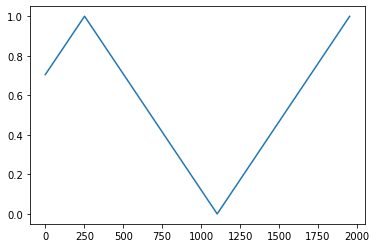

In [126]:
plt.plot([lin_phase(k) for k in range(0, full2, 10000)])

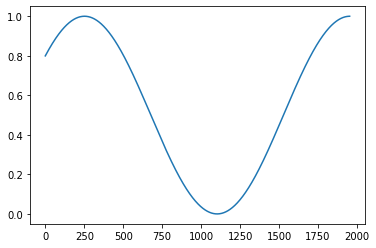

In [127]:
plt.plot([cos_phase(k) for k in range(0, full2, 10000)])